# Preprocessing and clustering tutorial on scanpy

First, install the relevant modules and set figure params. 

In [2]:
import scanpy as sc
import anndata as ad
import pooch
import numpy as np
import seaborn as sns

In [3]:
# Set global plotting parameters to make figures nicer
sc.set_figure_params(dpi=50, facecolor="white")

## Download data
Next download the relevant data using anndata package. The data used in this basic preprocessing and clustering tutorial was collected from bone marrow mononuclear cells of healthy human donors and was part of openproblem’s NeurIPS 2021 benchmarking dataset [Luecken et al., 2021]. The samples used in this tutorial were measured using the 10X Multiome Gene Expression and Chromatin Accessability kit.  

The anndata object is specifically designed for matrix-like data. For example, you can have n observations which can each be represented as d dimensional vectors. Eg: each row corresponds to a cell with a barcode, and each column correpsonds to a gene with gene-id. Furthermore, each cell and each gene has additional meta-data like 1) donor information for cell, 2) alternative gene symbols for each gene - https://anndata.readthedocs.io/en/stable/tutorials/notebooks/getting-started.html. 

https://adamgayoso.github.io/posts/ten_min_to_adata/


In [4]:
# Create a pooch object that downloads, caches and retrieves data files. Scache the downloaded data data directory
exampledat = pooch.create(
    path=pooch.os_cache("/Users/sshen4/Documents/singlecell_QTL_analysis/testing_methods/data"), 
    base_url="doi:10.6084/m9.figshare.22716739.v1/"
    )
exampledat.load_registry_from_doi()

In [5]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = exampledat.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

/Users/sshen4/Library/Application Support/hatch/env/virtual/scanpy-tut/3qmyJ1HI/scanpy-tut/lib/python3.13/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/sshen4/Library/Application Support/hatch/env/virtual/scanpy-tut/3qmyJ1HI/scanpy-tut/lib/python3.13/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


/Users/sshen4/Library/Application Support/hatch/env/virtual/scanpy-tut/3qmyJ1HI/scanpy-tut/lib/python3.13/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/sshen4/Library/Application Support/hatch/env/virtual/scanpy-tut/3qmyJ1HI/scanpy-tut/lib/python3.13/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/sshen4/Library/Application Support/hatch/env/virtual/scanpy-tut/3qmyJ1HI/scanpy-tut/lib/python3.13/site-packages/anndata/_core/anndata.py:1774: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

We can see that the variable names are not unique (some genes and some cells are duplicated). We run the recommended function to append a duplicate index element to make them unique. 

In [7]:
adata.var_names_make_unique()
adata.obs_names_make_unique()

So what is stored in an anndata object and how?   
`adata.var_names` - the gene names  
`adata.obs_names` - the cell names  
`adata.obs` - cell-level metadata  
`adata.var` - gene-level metadata  

In [8]:
print(adata.var_names[:5]) # contains the gene names
print(adata.obs_names[:5]) # contains the cell names

print("cell-level metadata")
print(adata.obs.head())
print("gene-level metadata")
print(adata.var.head())

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3'], dtype='object')
Index(['AAACCCAAGGATGGCT-1', 'AAACCCAAGGCCTAGA-1', 'AAACCCAAGTGAGTGC-1',
       'AAACCCACAAGAGGCT-1', 'AAACCCACATCGTGGC-1'],
      dtype='object')
cell-level metadata
                   sample
AAACCCAAGGATGGCT-1   s1d1
AAACCCAAGGCCTAGA-1   s1d1
AAACCCAAGTGAGTGC-1   s1d1
AAACCCACAAGAGGCT-1   s1d1
AAACCCACATCGTGGC-1   s1d1
gene-level metadata
Empty DataFrame
Columns: []
Index: [MIR1302-2HG, FAM138A, OR4F5, AL627309.1, AL627309.3]


In [9]:
adata.obs["sample"].nunique() # There are two donors 

print("There are ", adata.obs["sample"].nunique(), "  donors in the dataset")

There are  2   donors in the dataset


In [10]:
adata.var["mt"] = adata.var_names.str.startswith("MT-") # Mitochondrial genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL")) # Ribosomal genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]") # hemoglobin genes

In [11]:
# Investigate QC metrics

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

In [12]:
adata.obs_names

Index(['AAACCCAAGGATGGCT-1', 'AAACCCAAGGCCTAGA-1', 'AAACCCAAGTGAGTGC-1',
       'AAACCCACAAGAGGCT-1', 'AAACCCACATCGTGGC-1', 'AAACCCACATTCTCTA-1',
       'AAACCCAGTCCGCAGT-1', 'AAACCCAGTGCATACT-1', 'AAACCCAGTTGACGGA-1',
       'AAACCCATCGATACTG-1',
       ...
       'TTTGGTTCATGTTACG-1', 'TTTGGTTGTCTCACAA-1', 'TTTGGTTTCCCATTCG-1',
       'TTTGGTTTCCGTCCTA-1', 'TTTGGTTTCTTGCGCT-1', 'TTTGTTGAGAGTCTGG-1',
       'TTTGTTGCAGACAATA-1', 'TTTGTTGCATGTTACG-1', 'TTTGTTGGTAGTCACT-1',
       'TTTGTTGTCGCGCTGA-1'],
      dtype='object', length=17125)

Inspect the QC metrics:
- `n_genes_by_counts` in .obs is the number of genes with positive counts in a cell,
- `total_counts` is the total number of counts for a cell, this might also be known as library size, and
- `pct_counts_mt` is the proportion of total counts for a cell which are mitochondrial.

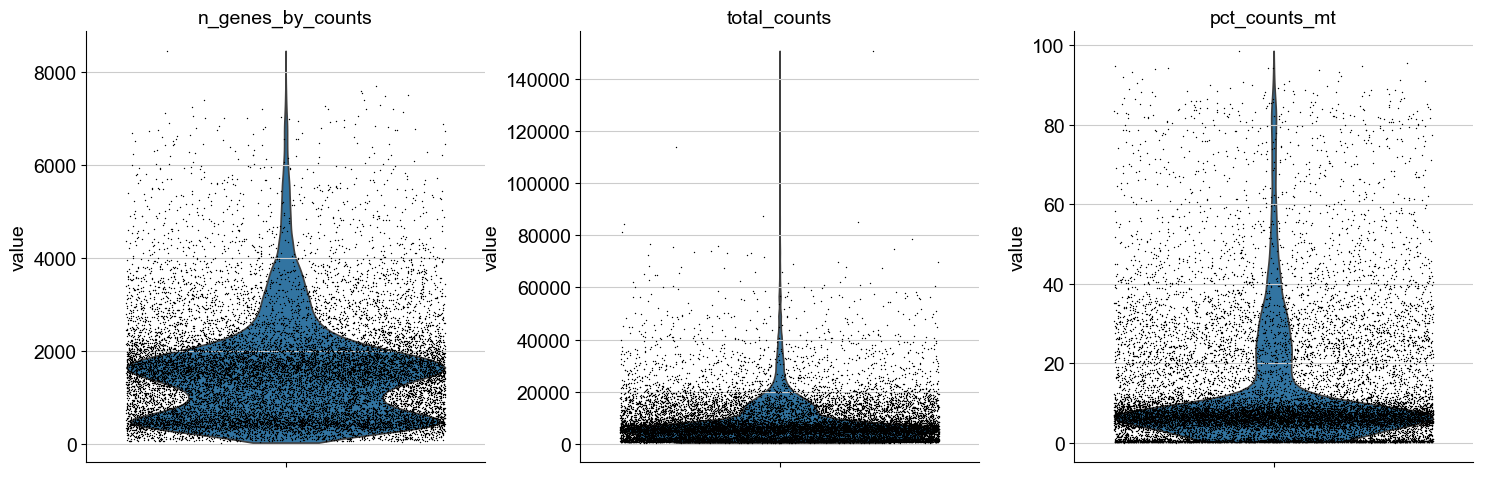

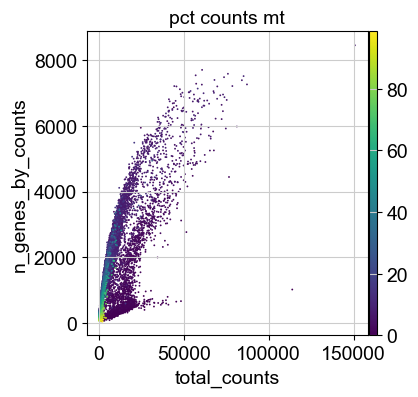

In [13]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [ ]:
@@@@
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

The scattergraph at the bottom is telling us how many UMIs were counted per cell (x-axis) and comparing this to the number of unique genes counter per cell. The colour corresponds to the percentage of the UMIs that can be attributed to mitochondrial genes. 

## Filtering

The recommendation is to conduct some cell-level and gene-level filtering. It's sometimes unclear whether the cell/gene-level observations are actual outliers due to bad quality, or whether there is interesting biology driving such results. The recommendation is to start with a permissive filtering strategy and revisit later. We filter cells with less than 100 genes expressed and genes that are detected in less than 3 cells (out of >17k cells). 

When there are multiple batches, QC should be performed for each sample individually as QC thresholds can vary substantially between batches. 

'sc.pp.filter_cells' and 'sc.pp.filter_genes' are used to filter cells and genes. 

In [14]:
print("There are initially ", adata.n_obs, " cells across all individuals")
print("There are initially ", adata.n_vars, " genes across all cells and all individuals")

There are initially  17125  cells across all individuals
There are initially  36601  genes across all cells and all individuals


We can also do more sophisticated filtering (based on the sc best practices book: [filtering low quality cells](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html#filtering-low-quality-cells)). When a cell has a low number of detected genes, a low count depth and a high fraction of mitochondrial counts, it could have a broken membrane which indicates cell death. 
  
When we have lots of cells and genes, manually identifying outliers by looking at the distribution of QC covariates can be quite time consuming and difficult. An alternative option is to conduct thresholding via the MAD (Median Absolute Deviations). For a given QC metric of an observation Xi, the MAD = median(|Xi-median(X)|). The MAD is a robust statistic of the variability of a metric. Previous [publications](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02136-7) have filtered cells as outliers if they differ by 5 MADs, which Theis lab feels is permissive. Oftentimes, it makes sense to be permissive at the beginning, and then re-filter following annotation of cells. 

In [ ]:
# More sophisticated filtering based on MAD

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier


adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

We may also want to detect and remove ambient mRNA.

In [ ]:
# Detect and remove ambient mRNA using soupX and decontX. 

In [28]:
# Before filtering
initial_cells = adata.n_obs
initial_genes = adata.n_vars

# Filter cells
sc.pp.filter_cells(adata, min_genes=100)
# Filter genes
sc.pp.filter_genes(adata, min_cells=3)

# After filtering
filtered_cells = adata.n_obs
filtered_genes = adata.n_vars

# Number of cells removed
print(f"Cells removed: {initial_cells - filtered_cells}")
print(f"Genes removed: {initial_genes - filtered_genes}")

print("There are now ", filtered_cells, " cells and ", filtered_genes, " genes across all individuals in the dataset." )

Cells removed: 0
Genes removed: 0
There are now  17041  cells and  23427  genes across all individuals in the dataset.


## Doublet detection

Identify and remove artificial cell multiplets (doublets or multiplets) that can occur during droplet or microwell-based encapsulation. A doublet is when two or more cells are captured instead of a single cell. The transcriptomic profile of this cell does not represent any real biological cell type and can confound downstream analyses.   
  
Doublets can create spurious clusters, can misleadingly show marker genes of multiple cell types and can lead to overestimation of cell types.  Python tools to detect doublets include Scrublet and Solo.  
  
Scrublet predicts cell doublets using a nearest neighbor classifier of observed transcriptomes and simulated doublets.  
   
Cells can be filtered out if they're called as doublets, or we can cluster and then filter out clusters with high doublet scores.  

In [29]:
sc.pp.scrublet(adata, batch_key="sample")

ValueError: threshold is None and thus scrublet requires skimage, but skimage is not installed.